In [58]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [54]:
#Part A: load dataset
imdb_df = pd.read_csv(r'C:\Users\user\Downloads\Imdb - data_imdb.csv')
imdb_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [19]:
#1. Data Exploration and Preprocessing
imdb_df.isnull().sum() #missing values
imdb_df['sentiment'].value_counts() #check balance

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

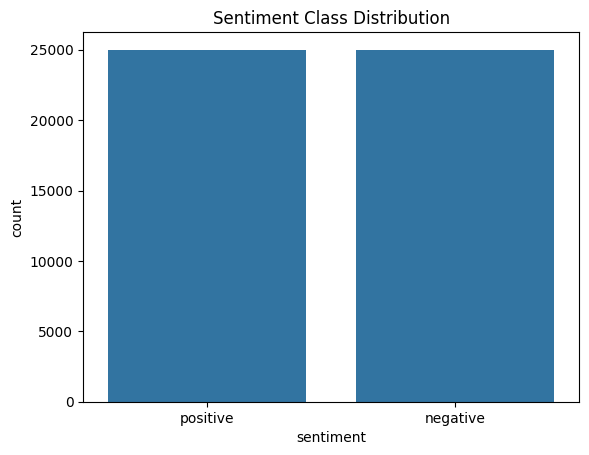

In [20]:
#balance plot
sns.countplot(data=imdb_df, x='sentiment')
plt.title("Sentiment Class Distribution")
plt.show()

In [21]:
#analyzing review length
imdb_df['review_length'] = imdb_df['review'].apply(len)
imdb_df['word_count'] = imdb_df['review'].apply(lambda x: len(str(x).split()))
imdb_df[['review_length', 'word_count']].describe()

,review_length,word_count
count,50000.000000,50000.000000
mean,1309.367720,231.146580
std,989.759532,171.349956
min,7.000000,1.000000
25%,699.000000,126.000000
50%,970.000000,173.000000
75%,1590.000000,280.000000
max,13704.000000,2470.000000


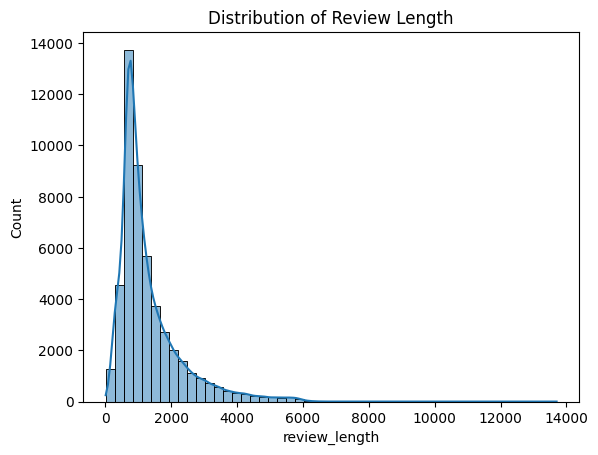

In [28]:
sns.histplot(imdb_df['review_length'], bins=50, kde=True)
plt.title("Distribution of Review Length")
plt.show()

In [46]:
# Perform data cleaning and text preprocessing

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text.lower())
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

imdb_df['cleaned_review'] = imdb_df['review'].apply(clean_text)

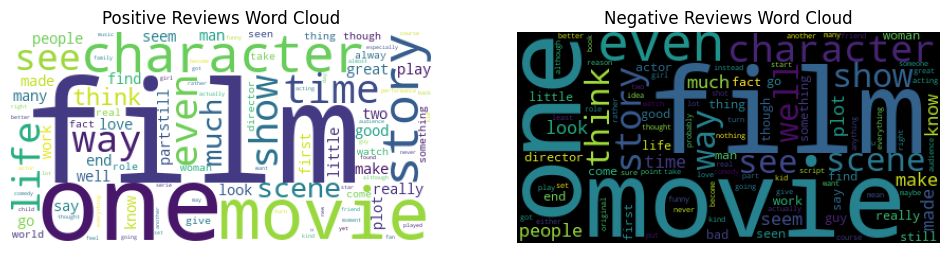

In [40]:
positive_text = " ".join(imdb_df[imdb_df['sentiment']=='positive']['cleaned_review'])
negative_text = " ".join(imdb_df[imdb_df['sentiment']=='negative']['cleaned_review'])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(max_words=100, background_color='white').generate(positive_text))
plt.title("Positive Reviews Word Cloud")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(WordCloud(max_words=100, background_color='black').generate(negative_text))
plt.title("Negative Reviews Word Cloud")
plt.axis('off')
plt.show()


In [43]:
#2. Feature Engineering
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(imdb_df['cleaned_review']).toarray()

from sklearn.preprocessing import LabelEncoder
y = LabelEncoder().fit_transform(imdb_df['sentiment'])  # positive = 1, negative = 0

In [55]:
#3. Model Development

#model training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [56]:
# 4. Model Evaluation
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

              precision    recall  f1-score   support

    Negative       0.90      0.87      0.89      4961
    Positive       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Accuracy: 0.8893
ROC-AUC: 0.9579384809771827


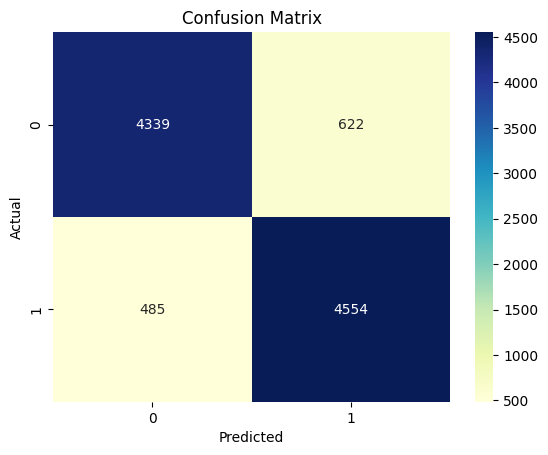

In [57]:
# Evaluate the model’s performance using appropriate metrics.
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='YlGnBu')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [59]:
feature_names = tfidf.get_feature_names_out()
coefficients = model.coef_[0]
top_pos_idx = np.argsort(coefficients)[-20:]
top_neg_idx = np.argsort(coefficients)[:20]

print("Top Positive Words:")
print(feature_names[top_pos_idx])

print("Top Negative Words:")
print(feature_names[top_neg_idx])


Top Positive Words:
['superb' 'entertaining' 'well' 'definitely' 'perfectly' 'enjoyable'
 'fantastic' 'today' 'highly' 'enjoyed' 'hilarious' 'loved' 'favorite'
 'brilliant' 'amazing' 'best' 'wonderful' 'perfect' 'excellent' 'great']
Top Negative Words:
['worst' 'waste' 'awful' 'bad' 'boring' 'poor' 'terrible' 'nothing'
 'poorly' 'dull' 'horrible' 'disappointment' 'worse' 'disappointing'
 'fails' 'unfortunately' 'supposed' 'lame' 'avoid' 'annoying']


In [60]:
def predict_sentiment(text):
    cleaned = clean_text(text)
    vector = tfidf.transform([cleaned])
    pred = model.predict(vector)
    prob = model.predict_proba(vector)
    return 'Positive' if pred[0] == 1 else 'Negative', round(max(prob[0]), 3)

new_review = "The plot was boring and the acting was terrible."
sentiment, confidence = predict_sentiment(new_review)
print(f"Predicted Sentiment: {sentiment} (Confidence: {confidence})")

Predicted Sentiment: Negative (Confidence: 1.0)


In [ ]:
''' Insights:-
No missing values were found, indicating a clean dataset ready for analysis.
Class balance ensures unbiased model training and evaluation as we observed equal of positive and negative reviews.
Most reviews are between 700 to 1600 characters (25th to 75th percentile), and around 125–280 words.
High ROC-AUC (0.96) indicates excellent class separability.
Strong indicators of displeasure, regret, and dissatisfaction, often signaling critical reviews which is useful for generating a sentiment lexicon or keyword-based filtering.

Enhancement:Adding word cloud visualizations for positive/negative words.'''